# Time-Testing on Outlier and Drift Detection Payloads

## Install Dependencies

In [39]:
# Uncomment when running for the first time
# !pip install -q tfds-nightly tensorflow matplotlib
# !pip install alibi-detect

In [3]:
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.od import OutlierAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
from alibi_detect.cd.tensorflow import preprocess_drift
from alibi_detect.cd import KSDrift
from alibi_detect.models.tensorflow.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

import logging
import os
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, \
    Dense, Layer, Reshape, InputLayer, Flatten
from tqdm import tqdm

import base64
from PIL import Image
import PIL
import cv2
import io
import time
import glob
from time import process_time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load Data and Pre-Process

### German Traffic Benchmark Dataset (inlier)

In [4]:
import zipfile

! wget -N https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

with zipfile.ZipFile('GTSRB_Final_Test_Images.zip', 'r') as zip_ref:
    print('Unzipping...')
    zip_ref.extractall()

! wget -N https://raw.githubusercontent.com/aditbiswas1/P2-traffic-sign-classifier/master/signnames.csv

--2021-06-29 23:19:19--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘GTSRB_Final_Test_Images.zip’ not modified on server. Omitting download.

Unzipping...
--2021-06-29 23:19:23--  https://raw.githubusercontent.com/aditbiswas1/P2-traffic-sign-classifier/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-06-29 23:19:23 

In [5]:
def get_sign_images(width, height):
    X_train = []
    X_test = []
    
    # total # of images = 12630
    for index, file in enumerate(glob.glob('GTSRB/Final_Test/Images/*ppm')):
        image = Image.open(file)
        resized_image = image.resize((width, height))
        array = np.array(resized_image)
        if index < 10000:
            # Load image file to array:
            X_train.append(array)
        elif index < 12000 and index >= 10000:
            X_test.append(array)
    
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)

    X_train = X_train.astype("float32") / 255
    X_test = X_test.astype("float32") / 255
        
    return (X_train, X_test)

(10000, 32, 32, 3)
(10000, 64, 64, 3)


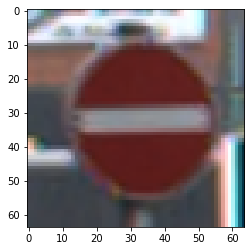

In [6]:
signs_32 = get_sign_images(32, 32)[0]
signs_64 = get_sign_images(64, 64)[0]

print(signs_32.shape)
print(signs_64.shape)

# show image from dataset
plt.imshow(signs_64[0])

### Stanford Cars196 (outlier)

In [7]:
ds = tfds.load('cars196', split='train', as_supervised=True)
cars = []

for image, label in tfds.as_numpy(ds):
    cars.append(image)
    
cars = np.asarray(cars)


INFO:absl:Load dataset info from /home/ec2-user/tensorflow_datasets/cars196/2.0.1
INFO:absl:Reusing dataset cars196 (/home/ec2-user/tensorflow_datasets/cars196/2.0.1)
INFO:absl:Constructing tf.data.Dataset cars196 for split train, from /home/ec2-user/tensorflow_datasets/cars196/2.0.1
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [8]:
def resize(images, width, height, show_image=False):
    resized_images = []
    for image_array in images:
        image = Image.fromarray(image_array)
        if show_image:
            image.show()
        resized_image = image.resize((width, height))
        resized_image_array = np.array(resized_image)
        resized_images.append(resized_image_array)
    resized_images = np.asarray(resized_images)
    return resized_images

In [9]:
cars_32 = resize(cars, 32, 32)
cars_64 = resize(cars, 64, 64)

In [10]:
cars_32 = cars_32.astype("float32") / 255
cars_64 = cars_64.astype("float32") / 255

float32


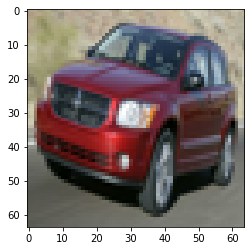

In [11]:
print(cars_32.dtype)
plt.imshow(cars_64[100])

## Outlier Detection Time-Testing

This notebook utilizes models that were trained in a separate repository. Here’s some information about how the auto-encoders were trained: outlier_detector_32 was trained on 10,000 32x32x3 GTSRB images using 75 epochs. outlier_detector_64 was trained on 10,000 64x64x3 GTSRB images using 30 epochs. Both models were trained in 25 minutes. However, note that outlier detection performance will increase with more training time. drift_detector_32 was initialized with 10,000 GTSRB images.

In [12]:
load_outlier_detector = True

filepath_32 = 'outlier_detector_32'
filepath_64 = 'outlier_detector_64'
if load_outlier_detector:  # load pretrained outlier detector
    od_32 = load_detector(filepath_32)
    od_64 = load_detector(filepath_64)

In [13]:
def get_batches(data, sizes):
    batches = []
    for s in sizes:
        if s < len(data):
            batch = data[:s]
            batches.append(batch)
        else:
            enlarged = np.copy(data)
            while len(enlarged) < s:
                larger = np.concatenate((np.copy(enlarged), np.copy(data)))
                enlarged = larger
            batch = enlarged[:s]
            batches.append(batch)
    return batches

def get_wall_times(od, inputs):
    times = []
    for x in inputs:
        start = time.time()
        od_preds = od.predict(x,
                              outlier_type='instance',    # use 'feature' or 'instance' level
                              return_feature_score=True,  # scores used to determine outliers
                              return_instance_score=True)
        end = time.time()
        t = end - start
        times.append(t)
    return times

# sum of user and system CPU times
def get_cpu_times(od, inputs):
    times = []
    for x in inputs:
        start = process_time() 
        od_preds = od.predict(x,
                              outlier_type='instance',    # use 'feature' or 'instance' level
                              return_feature_score=True,  # scores used to determine outliers
                              return_instance_score=True)
        end = process_time() 
        t = end - start
        times.append(t)
    return times

def plot(x1, y1, x2, y2, label_1, label_2, x_label, y_label, title):
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)
    
    m1, b1 = np.polyfit(x1, y1, 1)
    m2, b2 = np.polyfit(x2, y2, 1)

    plt.plot(x1, m1*x1 + b1)
    plt.plot(x2, m2*x2 + b2)

    plt.scatter(x1, y1, label=label_1, color= "blue", s=30)
    plt.scatter(x2, y2, label=label_2, color= "red", s=30)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

    print(f"Blue: y = {m1}*x + {b1}")
    print(f"Red: y = {m2}*x + {b2}")

In [14]:
sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 16000]
batches_32 = get_batches(cars_32, sizes)
batches_64 = get_batches(cars_64, sizes)
print(batches_32[0].shape)

(1000, 32, 32, 3)


In [15]:
wall_times_32 = get_wall_times(od_32, batches_32)
cpu_times_32 = get_cpu_times(od_32, batches_32)
print(wall_times_32)
print(cpu_times_32)

[0.5369150638580322, 0.9997780323028564, 1.4842073917388916, 2.0229053497314453, 2.525470495223999, 3.020721912384033, 3.523808002471924, 4.017379283905029, 8.011279344558716]
[3.4320328750000044, 7.152439313000002, 10.688075314000002, 14.365444824000008, 17.89926531399999, 21.452360700999975, 25.06822186300002, 28.63078803100001, 57.334797881999975]


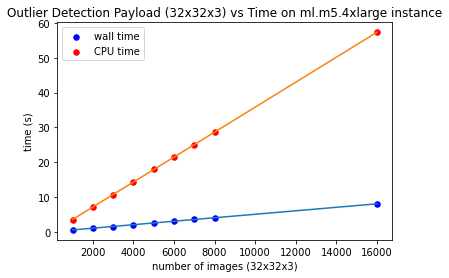

Blue: y = 0.0004999713457726503*x + 0.015994988444123993
Red: y = 0.0035884179109749283*x + -0.06381169485514507


In [16]:
plot(sizes, wall_times_32, sizes, cpu_times_32, "wall time", "CPU time", "number of images (32x32x3)", "time (s)", "Outlier Detection Payload (32x32x3) vs Time on ml.m5.4xlarge instance")

In [17]:
wall_times_64 = get_wall_times(od_64, batches_64)
cpu_times_64 = get_cpu_times(od_64, batches_64)
print(wall_times_64)
print(cpu_times_64)

[2.0016493797302246, 3.9790658950805664, 5.958456039428711, 7.934719800949097, 9.909765243530273, 11.884013891220093, 13.852726697921753, 15.836085557937622, 31.654440879821777]
[13.036440653, 26.036702450999883, 39.38809705299991, 52.40830285300012, 64.4952948770001, 77.27290186200003, 89.79804103200013, 102.77265742200007, 206.59028390599997]


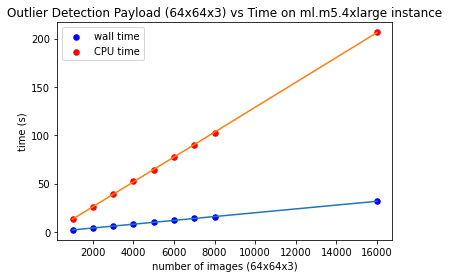

Blue: y = 0.001976625247420043*x + 0.025156724419767868
Red: y = 0.012871564314305715*x + 0.2752641961225687


In [18]:
plot(sizes, wall_times_64, sizes, cpu_times_64, "wall time", "CPU time", "number of images (64x64x3)", "time (s)", "Outlier Detection Payload (64x64x3) vs Time on ml.m5.4xlarge instance")

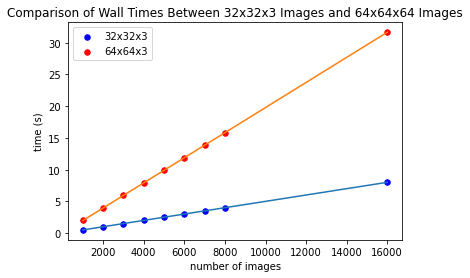

Blue: y = 0.0004999713457726503*x + 0.015994988444123993
Red: y = 0.001976625247420043*x + 0.025156724419767868


In [19]:
plot(sizes, wall_times_32, sizes, wall_times_64, "32x32x3", "64x64x3", "number of images", "time (s)", "Comparison of Wall Times Between 32x32x3 Images and 64x64x64 Images")

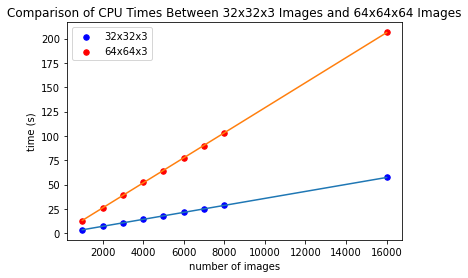

Blue: y = 0.0035884179109749283*x + -0.06381169485514507
Red: y = 0.012871564314305715*x + 0.2752641961225687


In [20]:
plot(sizes, cpu_times_32, sizes, cpu_times_64, "32x32x3", "64x64x3", "number of images", "time (s)", "Comparison of CPU Times Between 32x32x3 Images and 64x64x64 Images")

## Outlier Detection Accuracy

In [21]:
def wrong_predictions(inlier_od_preds, outlier_od_preds, sample_size):
    #false positives
    false_positive_indices = []
    for i, p in enumerate(inlier_od_preds["data"]["is_outlier"]):
        if p == 1:
            false_positive_indices.append(i)

    false_positive_scores = []
    for i in false_positive_indices:
        score = inlier_od_preds["data"]["instance_score"][i]
        false_positive_scores.append(score)

    false_positives = list(zip(false_positive_indices, false_positive_scores))
    # false_positive_rate = len(false_positives) / sample_size
    
    # false negatives
    false_negative_indices = []
    for i, p in enumerate(outlier_od_preds["data"]["is_outlier"]):
        if p == 0:
            false_negative_indices.append(i)

    false_negative_scores = []
    for i in false_negative_indices:
        score = outlier_od_preds["data"]["instance_score"][i]
        false_negative_scores.append(score)

    false_negatives = list(zip(false_negative_indices, false_negative_scores))
    # false_negative_rate = len(false_negatives) / sample_size
    
    return {"false_positives": false_positives, "false_negatives": false_negatives}

def accuracy(false_positives, false_negatives, total_predictions):
    correct_predictions = total_predictions - (len(false_positives) + len(false_negatives))
    accuracy = correct_predictions / total_predictions
    return accuracy    

def precision(true_positives, false_positives):
    return true_positives / (true_positives + false_positives)

def recall(true_positives, false_negatives):
    return true_positives / (true_positives + false_negatives)

def f1(precision, recall):
    return 2 * ((precision * recall) / (precision + recall))

# F0.5-Measure (beta=0.5): More weight on precision, less weight on recall
# F1-Measure (beta=1.0): Balance the weight on precision and recall
# F2-Measure (beta=2.0): Less weight on precision, more weight on recall

def fbeta(beta, precision, recall):
    return ((1 + pow(beta, 2)) * precision * recall) / (pow(beta, 2) * precision + recall)

In [22]:
X = signs_32[:5000]
print('Current threshold: {}'.format(od_32.threshold))
od_32.infer_threshold(X, threshold_perc=95)
print('New threshold: {}'.format(od_32.threshold))

Current threshold: 0.015
New threshold: 0.007340545859187842


In [23]:
inlier_sample_size = 5000
outlier_sample_size = 5000

In [38]:
inlier_data = signs_32[:inlier_sample_size]

inlier_od_preds = od_32.predict(inlier_data,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

Inlier dataset: 


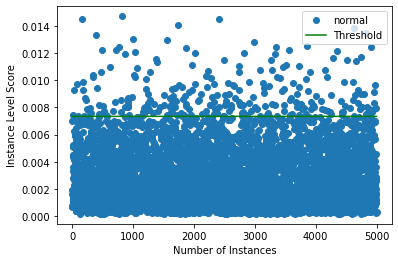

In [25]:
print("Inlier dataset: ")

target = np.zeros(inlier_data.shape[0],).astype(int) 
labels = ['normal', 'outlier']
plot_instance_score(inlier_od_preds, target, labels, od_32.threshold)

In [26]:
cars_outlier_data = cars_32[:outlier_sample_size]

cars_od_preds = od_32.predict(cars_outlier_data,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

Outlier cars dataset: 


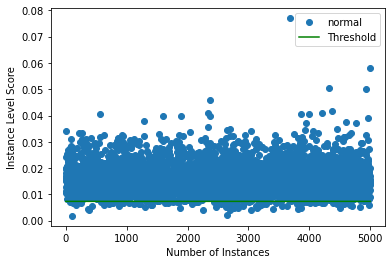

In [27]:
print("Outlier cars dataset: ")

target = np.zeros(cars_outlier_data.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(cars_od_preds, target, labels, od_32.threshold)

In [40]:
wrong_preds = wrong_predictions(inlier_od_preds, cars_od_preds, 100)
# print("False positives and false negatives using the cars dataset: ", wrong_preds)

od_acc = accuracy(wrong_preds["false_positives"], wrong_preds["false_negatives"], outlier_sample_size + inlier_sample_size)
print("Outlier detection accuracy on cars dataset: ", od_acc)

false_positives = len(wrong_preds["false_positives"])
false_negatives = len(wrong_preds["false_negatives"])
true_positives = outlier_sample_size - false_negatives
true_negatives = inlier_sample_size - false_positives

precision = precision(true_positives, false_positives)
recall = recall(true_positives, false_negatives)
f1 = f1(precision, recall)
fbeta = fbeta(2, precision, recall)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1)
print("Fbeta measure: ", fbeta)

Outlier detection accuracy on cars dataset:  0.9646
Precision:  0.9514185775359503
Recall:  0.9792
F1 score:  0.9651094027202839
Fbeta measure:  0.9735146743020759


## Drift Detection Time-Testing

In [29]:
tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=512)

# initialise drift detector
p_val = .05
cd = KSDrift(signs_32, p_val=p_val, preprocess_fn=preprocess_fn)

# we can also save/load an initialised detector
filepath = 'drift_detector_32'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

In [30]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

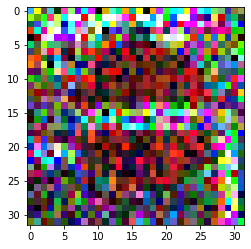

In [31]:
corrupted = []
signs_32_full = signs_32 * 255
for x in signs_32_full:
    x_corrupted = noisy('speckle', x)
    corrupted.append(x_corrupted)

corrupted = np.asarray(corrupted)
plt.imshow(corrupted[0].astype(int))

In [32]:
corrupted_preds = cd.predict(corrupted.astype("float32") / 255)
print("Drift on corrupted dataset:", corrupted_preds["data"]["is_drift"])

Drift on corrupted dataset: 1


In [33]:
preds = cd.predict(signs_32)
print("Drift on original dataset:", preds["data"]["is_drift"])

Drift on original dataset: 0


In [34]:
def get_wall_times_drift(cd, inputs):
    times = []
    for x in inputs:
        start = time.time()
        cd_preds = cd.predict(x)
        end = time.time()
        t = end - start
        times.append(t)
    return times

# sum of user and system CPU times
def get_cpu_times_drift(cd, inputs):
    times = []
    for x in inputs:
        start = process_time() 
        cd_preds = cd.predict(x)
        end = process_time() 
        t = end - start
        times.append(t)
    return times

In [35]:
sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 16000]
batches_drift = get_batches(corrupted, sizes)

wall_times_drift = get_wall_times_drift(cd, batches_32)
cpu_times_drift = get_cpu_times_drift(cd, batches_32)

print(wall_times_drift)
print(cpu_times_drift)

[0.13878798484802246, 0.23537206649780273, 0.32683753967285156, 0.41225242614746094, 0.49639034271240234, 0.5793612003326416, 0.663311243057251, 0.7482314109802246, 1.4055695533752441]
[1.0800914090000333, 2.1091581139999107, 3.1439607039999373, 4.169649112999878, 5.167027048000136, 6.1975146289998975, 7.2153371040001275, 8.236868318000006, 16.382106570000133]


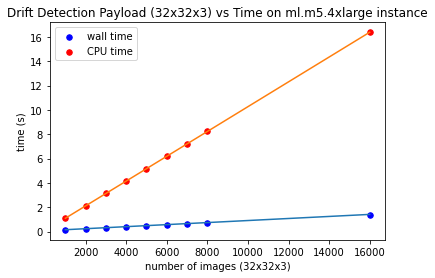

Blue: y = 8.39275277756715e-05*x + 0.07132025814322059
Red: y = 0.001019510451946391*x + 0.07635216753196794


In [37]:
plot(sizes, wall_times_drift, sizes, cpu_times_drift, "wall time", "CPU time", "number of images (32x32x3)", "time (s)", "Drift Detection Payload (32x32x3) vs Time on ml.m5.4xlarge instance")